# UNICON Dataset Technical Validation

This notebook presents a technical validation for selected subset of data in the UNICON dataset

### Load the needed libraries

In [1]:
# python
import datetime
from os.path import join, exists
from os import makedirs
import warnings
from datetime import datetime, timedelta

# data-science
import pandas as pd
import scipy
import numpy as np
import matplotlib.pyplot as plt

#Model building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import tree
from sklearn import neighbors
import xgboost as xgb
from sklearn.neural_network import MLPRegressor

from prettytable import PrettyTable
from sklearn import metrics 

%pylab inline
%matplotlib inline
plt.rcParams['figure.figsize'] = [18, 5]
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

Populating the interactive namespace from numpy and matplotlib


c:\users\20522516\appdata\local\programs\python\python37\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### Load data files

#### Load data files from the located folder

In [2]:
BASE_PATH = "data/"

### Load Meta information of the dataset
Let's visualise the campus and building meta information of the UNICON dataset

##### Campus Meta Data available in the UNICON Dataset

In [3]:
campus_meta_data_path = BASE_PATH + 'campus_meta.csv'
campus_meta_data = pd.read_csv(campus_meta_data_path)
campus_meta_data

,id,name,capacity
0,1,Bundoora,26000
1,2,Albury-Wodonga,800
2,3,Bendigo,5000
3,4,Mildura,500
4,5,Shepparton,700


##### Building Meta Data available in the UNICON Dataset 

In [5]:
campus_building_meta_data_path = BASE_PATH + 'building_meta.csv'
campus_building_meta_data = pd.read_csv(campus_building_meta_data_path, keep_default_na=False)
campus_building_meta_data

,campus_id,id,built_year,category,gross_floor_area,room_area,capacity
0,1,1,,other,,,
1,1,2,,other,,,
2,1,3,,other,,,
3,1,4,1967,mixed use,145558.14000000016,1790.17,79.0
4,1,5,1899,other,0.0,,
...,...,...,...,...,...,...,...
59,1,60,1966,mixed use,1208347.8399999996,7756.220000000001,691.0
60,1,61,1966,mixed use,1208347.8399999996,7756.220000000001,691.0
61,1,62,1968,teaching,1274716.1699999983,7615.16,1331.0
62,1,63,1972,mixed use,1640647.3800000031,12387.619999999997,1362.0


### Load and visualise NMI electricity consumption data

This repository contains subset of electricity consumption data of #5 NMI in 2019

In [6]:
data_nmi_electricity_consumption_path = BASE_PATH + 'nmi_consumption_sub.csv'
data_nmi_electricity_consumption = pd.read_csv(data_nmi_electricity_consumption_path)
data_nmi_electricity_consumption

,campus_id,meter_id,timestamp,consumption,demand_kW,demand_kVA
0,1.0,5,2019-01-01 00:00:00,8.512,34.048,34.048
1,1.0,5,2019-01-01 00:15:00,7.648,30.592,30.592
2,1.0,5,2019-01-01 00:30:00,7.584,30.336,30.336
3,1.0,5,2019-01-01 00:45:00,7.712,30.848,30.848
4,1.0,5,2019-01-01 01:00:00,7.616,30.464,30.464
...,...,...,...,...,...,...
33994,1.0,5,2019-12-30 22:45:00,9.100,36.400,36.400
33995,1.0,5,2019-12-30 23:00:00,8.600,34.400,34.588
33996,1.0,5,2019-12-30 23:15:00,9.300,37.200,37.202
33997,1.0,5,2019-12-30 23:30:00,8.800,35.200,35.311


#### Visualise the demand of the #5 NMI

<AxesSubplot:xlabel='timestamp'>

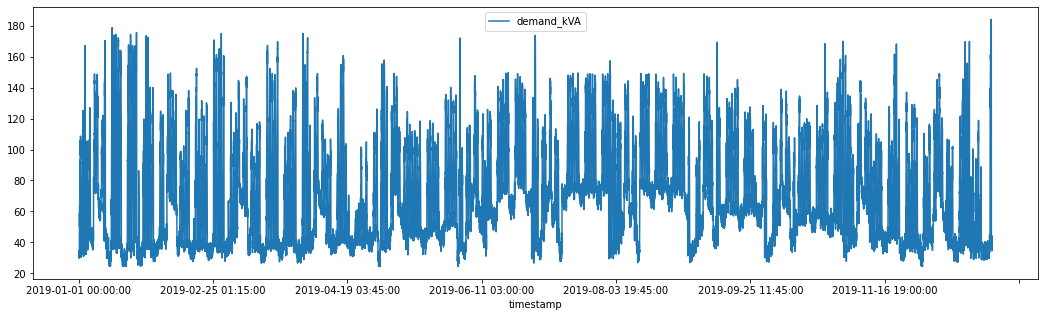

In [7]:
data_nmi_electricity_consumption[(data_nmi_electricity_consumption.meter_id==5) & (data_nmi_electricity_consumption.campus_id==1)][["timestamp", "demand_kVA"]].plot(x="timestamp", y="demand_kVA")

### Load and Visualise Weather information

In this given subset of the data, it contains weather information of Bundoora campus in 2019. We have only included the apparent temperature.

In [8]:
weather_data_path = BASE_PATH + 'weather_data_sub_1.csv'
weather_data = pd.read_csv(weather_data_path)
weather_data

,campus_id,timestamp,apparent_temperature,relative_humidity,wind_speed,wind_direction
0,1,2019-01-01 00:00:00,15.9,68.0,9.4,196.0
1,1,2019-01-01 00:01:00,15.8,68.0,9.4,203.0
2,1,2019-01-01 00:02:00,15.8,69.0,9.4,210.0
3,1,2019-01-01 00:03:00,16.2,69.0,7.6,219.0
4,1,2019-01-01 00:04:00,15.6,69.0,11.2,207.0
...,...,...,...,...,...,...
524095,1,2019-12-30 23:55:00,17.7,83.0,18.4,222.0
524096,1,2019-12-30 23:56:00,18.1,83.0,16.6,212.0
524097,1,2019-12-30 23:57:00,17.6,84.0,18.4,203.0
524098,1,2019-12-30 23:58:00,17.6,84.0,18.4,207.0


<AxesSubplot:xlabel='timestamp'>

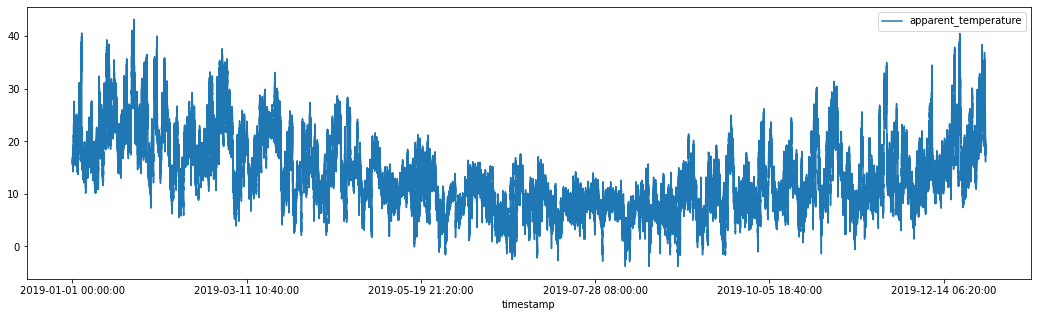

In [9]:
weather_data[["timestamp", "apparent_temperature"]].plot(x="timestamp", y="apparent_temperature")

### Load and visualise building electricity consumption data

This repository contains subset of electricity consumption data of building No #39 of Bundoora Campus in 2019

In [10]:
building_data_path = BASE_PATH + 'building_consumption_sub.csv'
building_data = pd.read_csv(building_data_path)
building_data

,campus_id,meter_id,timestamp,consumption
0,1,39,2019-01-01 00:15:00,30.75
1,1,39,2019-01-01 00:30:00,31.25
2,1,39,2019-01-01 00:45:00,30.50
3,1,39,2019-01-01 01:00:00,30.25
4,1,39,2019-01-01 01:15:00,31.75
...,...,...,...,...
33992,1,39,2019-12-30 22:45:00,36.75
33993,1,39,2019-12-30 23:00:00,35.75
33994,1,39,2019-12-30 23:15:00,34.50
33995,1,39,2019-12-30 23:30:00,36.00


<AxesSubplot:xlabel='timestamp'>

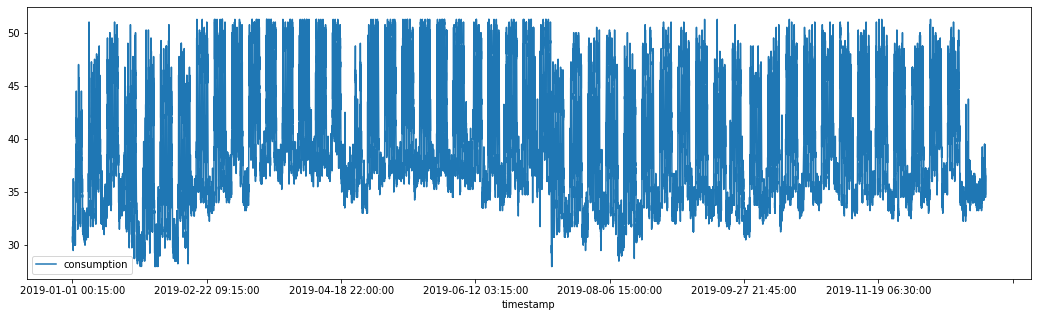

In [12]:
building_data.plot(x="timestamp", y="consumption")

### Building baseline models

In this section, it showcase how to build baseline models by combining the weather data

#### Merging building consumption with weather data

In [13]:
df_comumption_building_39 = building_data[(building_data.meter_id==39) & (building_data.campus_id==1)][["timestamp", "consumption"]]
weather_data_bundoora = weather_data[weather_data.campus_id==1]

df_building_consumption_with_weather = pd.merge(df_comumption_building_39, weather_data_bundoora, how="left", on=["timestamp"])
df_building_consumption_with_weather

,timestamp,consumption,campus_id,apparent_temperature,relative_humidity,wind_speed,wind_direction
0,2019-01-01 00:15:00,30.75,1.0,16.2,71.0,7.6,203.0
1,2019-01-01 00:30:00,31.25,1.0,16.1,73.0,7.6,216.0
2,2019-01-01 00:45:00,30.50,1.0,15.6,76.0,9.4,218.0
3,2019-01-01 01:00:00,30.25,1.0,16.3,77.0,5.4,230.0
4,2019-01-01 01:15:00,31.75,1.0,17.3,78.0,0.0,237.0
...,...,...,...,...,...,...,...
33992,2019-12-30 22:45:00,36.75,1.0,19.6,91.0,13.0,233.0
33993,2019-12-30 23:00:00,35.75,1.0,19.2,90.0,14.8,245.0
33994,2019-12-30 23:15:00,34.50,1.0,17.9,85.0,22.3,249.0
33995,2019-12-30 23:30:00,36.00,1.0,17.6,81.0,24.1,220.0


#### Creating data and time features

The energy consumption of the building is varying based on the time. Hence features such as hour and minutes can be derived from the timestamp. Most of the academic buildings consume less electricity during the weekends. Hence another binary feature added to indicate a given data is a weekend or not.

In [14]:
#Convert timestamp in to time object
df_building_consumption_with_weather['timestamp'] = pd.to_datetime(df_building_consumption_with_weather['timestamp'])

In [15]:
# Add hour as a feature from timestamp
df_building_consumption_with_weather['hour'] = df_building_consumption_with_weather.timestamp.dt.hour

In [16]:
# Add minutes feature from timestamp
df_building_consumption_with_weather['minutes'] = df_building_consumption_with_weather.timestamp.dt.minute

In [17]:
# Add a feature to indicate whether given day is a weekend or not
df_building_consumption_with_weather["is_weekend"] = df_building_consumption_with_weather.timestamp.dt.day_name().isin(['Saturday', 'Sunday'])
df_building_consumption_with_weather["is_weekend"] = df_building_consumption_with_weather["is_weekend"].astype(int)

In [18]:
#Drop any rows which contains null values
df_building_consumption_with_weather = df_building_consumption_with_weather.dropna()

In [19]:
#Data types of the features
df_building_consumption_with_weather.dtypes

timestamp               datetime64[ns]
consumption                    float64
campus_id                      float64
apparent_temperature           float64
relative_humidity              float64
wind_speed                     float64
wind_direction                 float64
hour                             int64
minutes                          int64
is_weekend                       int32
dtype: object

#### Create train and test data splits

In [20]:
X = df_building_consumption_with_weather[['apparent_temperature', 'relative_humidity', 'hour', 'minutes', 'is_weekend']].values
y = df_building_consumption_with_weather['consumption'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

#### Building models

In [21]:
#Multiple linear regression 
fuelLinReg = LinearRegression()
fuelLinReg.fit(X_train, y_train)

#Decision tree 
fuelDecisionTree = tree.DecisionTreeRegressor() # notice here we use the Regressor while for classification we used DecisionTreeClassifier
fuelDecisionTree.fit(X_train,y_train)

# XGBoost 
fuelXGB = xgb.XGBRegressor() # notice here we use the Regressor while for classification we used XGBClassifier
fuelXGB.fit(X_train,y_train)

# Neural network - Multi-layer Perceptron
fuelMLP = MLPRegressor() # notice here we use the Regressor while for classification we used MLPClassifier
fuelMLP.fit(X_train,y_train)

MLPRegressor()

#### Evaluating the model performance

In [22]:
regressors = [ fuelLinReg, fuelDecisionTree, fuelXGB, fuelMLP]
evalTable = PrettyTable(['Name', 'R-squared', 'MAE', 'RMSE', 'MAPE', 'MedAE' ], sortby='RMSE')
for i in regressors:
  # predict emissions
  y_predict = i.predict(X_test)
  evalTable.add_row( [ type(i).__name__, 
                      (round(i.score(X_test, y_test),3)), 
                      round(metrics.mean_absolute_error(y_test, y_predict),3),
                      round(metrics.mean_squared_error(y_test, y_predict, squared=False),3),
                      round(metrics.mean_absolute_percentage_error(y_test, y_predict),3),
                      round(metrics.median_absolute_error(y_test, y_predict),3),
                    ] )
print(evalTable)

+-----------------------+-----------+-------+-------+-------+-------+
|          Name         | R-squared |  MAE  |  RMSE |  MAPE | MedAE |
+-----------------------+-----------+-------+-------+-------+-------+
|      XGBRegressor     |   0.765   | 2.002 | 2.614 | 0.052 | 1.632 |
|      MLPRegressor     |   0.715   | 2.213 | 2.878 | 0.058 | 1.793 |
| DecisionTreeRegressor |   0.559   | 2.564 | 3.582 | 0.066 |  1.75 |
|    LinearRegression   |   0.343   | 3.566 | 4.371 | 0.091 | 3.119 |
+-----------------------+-----------+-------+-------+-------+-------+


Text(0, 0.5, 'Predicted')

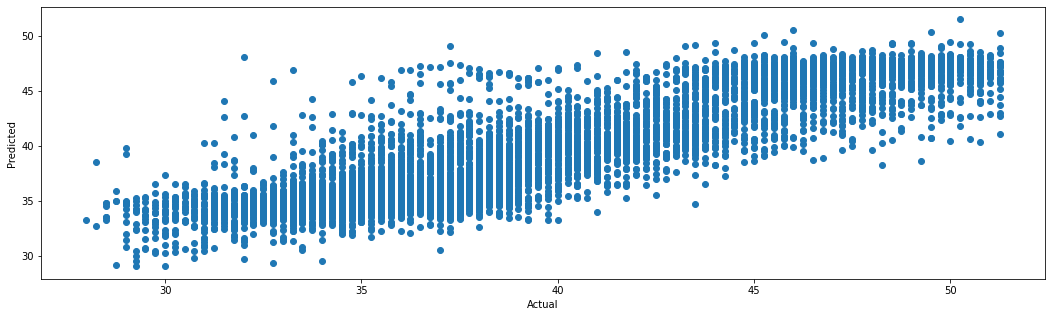

In [23]:
# Visualise actual vs predicted on a scatter plot 
y_predict = fuelXGB.predict(X_test)
plt.scatter(y_test, y_predict)
plt.xlabel('Actual')
plt.ylabel('Predicted')

### Load and visualise building submeter electricity consumption data

In this given subset of the data, it contains submeter energy consumption data of meter No #4 in 2021 which is located in building No #62

In [24]:
data_submeter_path = BASE_PATH + 'building_submeter_consumption_sub.csv'
data_submeter = pd.read_csv(data_submeter_path)
data_submeter

,building_id,id,campus_id,timestamp,consumption,current,voltage,power,power_factor
0,62.0,4,1.0,2021-01-01 09:00:00+11:00,0.0632,3.47,230.0,0.7589,0.95
1,62.0,4,1.0,2021-01-01 09:05:00+11:00,0.2510,6.89,230.0,3.0122,0.95
2,62.0,4,1.0,2021-01-01 09:10:00+11:00,0.2849,7.82,230.0,3.4187,0.95
3,62.0,4,1.0,2021-01-01 09:15:00+11:00,0.2904,7.97,230.0,3.4846,0.95
4,62.0,4,1.0,2021-01-01 09:20:00+11:00,0.3006,8.26,230.0,3.6077,0.95
...,...,...,...,...,...,...,...,...,...
50014,62.0,4,1.0,2021-12-24 08:45:00+11:00,0.6847,37.60,230.0,8.2163,0.95
50015,62.0,4,1.0,2021-12-24 08:50:00+11:00,0.6963,38.24,230.0,8.3552,0.95
50016,62.0,4,1.0,2021-12-24 08:55:00+11:00,0.6840,37.56,230.0,8.2077,0.95
50017,62.0,4,1.0,2021-12-24 09:00:00+11:00,0.6862,37.69,230.0,8.2344,0.95


<AxesSubplot:xlabel='timestamp'>

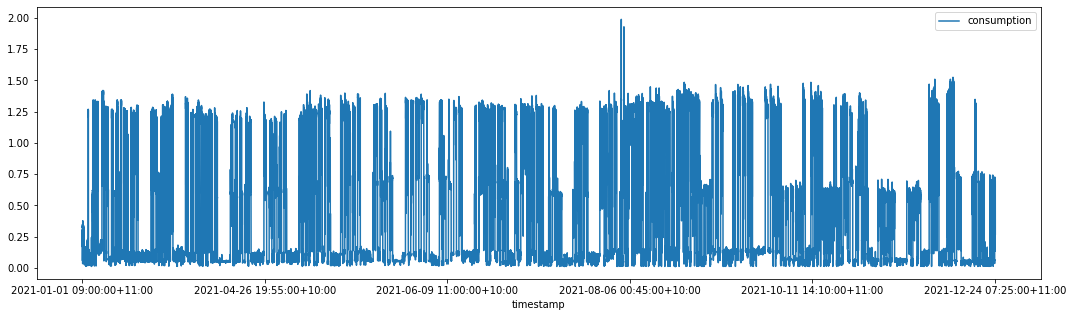

In [26]:
data_submeter.plot(x="timestamp", y="consumption")

### Load and visualise gas data

In the given subset of data, it contains the gas consumption data of Bundoora campus in 2019

In [27]:
data_gas_path = BASE_PATH + 'gas_consumption_sub.csv'
data_gas = pd.read_csv(data_gas_path)
data_gas

,campus_id,timestamp,consumption
0,1,2019-01-01 23:00:00,0.771294
1,1,2019-01-02 22:00:00,0.765869
2,1,2019-01-03 05:00:00,0.765925
3,1,2019-01-03 23:00:00,0.771124
4,1,2019-01-04 10:00:00,0.694145
...,...,...,...
9568,1,2019-12-20 09:00:00,9.749230
9569,1,2019-12-20 10:00:00,9.552524
9570,1,2019-12-20 11:00:00,16.112443
9571,1,2019-12-20 12:00:00,6.602246


<AxesSubplot:xlabel='timestamp'>

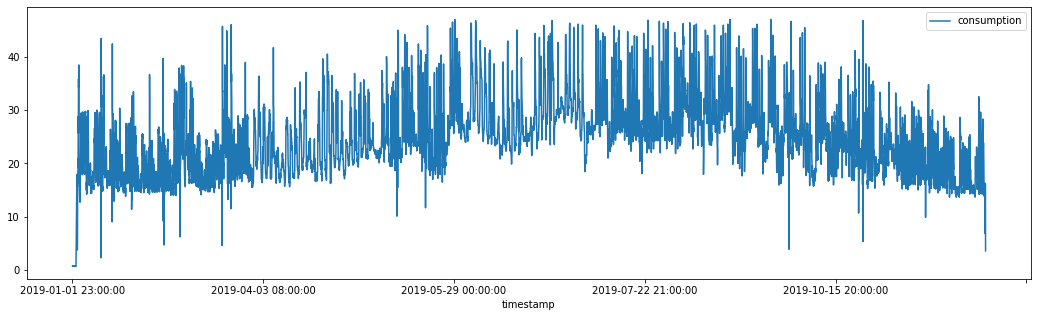

In [28]:
data_gas.plot(x="timestamp", y="consumption")

### Load and visualise water data

In the given subset of data, it contains the water consumption of meter No #5  in the Bundoora campus

In [29]:
data_water_path = BASE_PATH + 'water_consumption_sub.csv'
data_water = pd.read_csv(data_water_path)
data_water

,campus_id,meter_id,timestamp,consumption
0,1,5,2021-01-10 00:00:00,386.264
1,1,5,2021-01-10 00:15:00,386.264
2,1,5,2021-01-10 00:30:00,386.264
3,1,5,2021-01-10 00:45:00,386.264
4,1,5,2021-01-10 01:00:00,386.264
...,...,...,...,...
16331,1,5,2022-12-03 22:45:00,542.115
16332,1,5,2022-12-03 23:00:00,542.115
16333,1,5,2022-12-03 23:15:00,542.115
16334,1,5,2022-12-03 23:30:00,542.115


<AxesSubplot:xlabel='timestamp'>

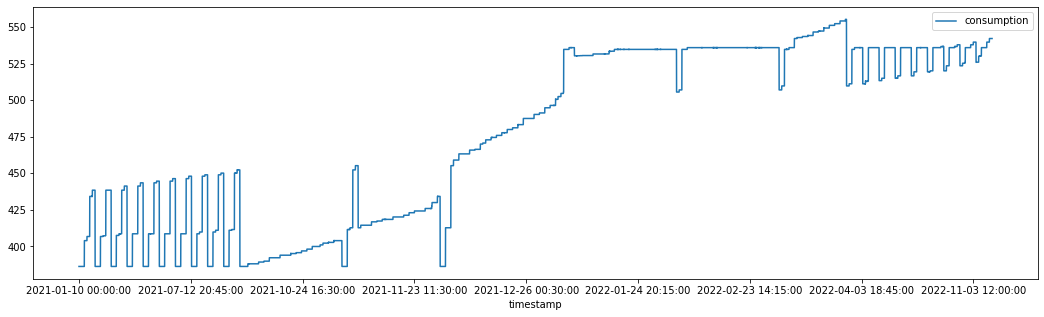

In [30]:
data_water.plot(x="timestamp", y="consumption")